# Missing data problem

We will begin by installing the library and downloading the data

In [1]:
%load_ext autoreload
%autoreload 2
import sys

! python3 -m pip install  "sep_plot @ git+https://github.com/SEP-software/sep-plot.git@6331a1e36d8e3cdb4cfbc3539f31bdad1eb465a7" 


  Using cached sep_plot-0.9.102-py2.py3-none-any.whl
  Using cached sep_python-0.9.89-py2.py3-none-any.whl
  Using cached generic_solver-1.0.7-py2.py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [3]:
! wget https://github.com/GP211/2023-fall-class-notebooks/raw/main/data/s2000.5


--2023-10-28 17:23:26--  https://github.com/GP211/2023-fall-class-notebooks/raw/main/data/s2000.5
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GP211/2023-fall-class-notebooks/main/data/s2000.5 [following]
--2023-10-28 17:23:26--  https://raw.githubusercontent.com/GP211/2023-fall-class-notebooks/main/data/s2000.5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39304 (38K) [text/plain]
Saving to: ‘s2000.5.15’

s2000.5.15          100%[===================>]  38.38K  --.-KB/s    in 0.04s   

2023-10-28 17:23:26 (1.05 MB/s) - ‘s2000.5.15’ saved [39304/39304]



## Read in the file

First we will look at the file and read it in two different ways, one using just python, one using pandas.

In [4]:
! cat s2000.5

VRTX     1       6297.000000       2298.000000      -1991.000000   
VRTX     2       6720.000000       2609.000000      -2158.000000   
VRTX     3       7102.000000       2891.000000      -2056.000000   
VRTX     4       7928.000000       3497.998047      -2128.000000   
VRTX     5       8311.000000       3779.000000      -2038.000000   
VRTX     6       8734.000000       4089.998047      -1847.000000   
VRTX     7       9116.000000       4371.000000      -1792.000000   
VRTX     8       9539.000000       4682.000000      -1826.000000   
VRTX     9      10748.000000       5570.998047      -1600.000000   
VRTX    10      11131.000000       5852.000000      -1620.000000   
VRTX    11      11554.000000       6163.000000      -1594.000000   
VRTX    12      11936.000000       6445.000000      -1631.000000   
VRTX    13      12742.000000       7037.000000      -1104.000000   
VRTX    14      13165.000000       7348.000000      -1412.000000   
VRTX    15      13568.000000       7643.998047  

In [5]:
import numpy as np
fl=open("s2000.5")
lines=fl.readlines()
x=[]
y=[]
z=[]
for ln in lines:
    vars=ln.split()
    x.append(float(vars[2]))
    y.append(float(vars[3]))
    z.append(float(vars[4]))
xar=np.array(x)
yar=np.array(y)
zar=np.array(z)

In [6]:
import pandas as pd

# Read the file into a DataFrame
df = pd.read_csv("s2000.5", delim_whitespace=True, header=None, usecols=[2, 3, 4], names=["x", "y", "z"])

# Convert columns to numpy arrays
xar = df["x"].values
yar = df["y"].values
zar = df["z"].values


## Create the model space

In [7]:
from sep_python import Hypercube
o1,d1,n1=5200,600,40
o2,d2,n2=-22000,800,40
reg_model=Hypercube.set_with_ns(ns=[n1,n2],os=[o1,o2],ds=[d1,d2],labels=["x","y"])

# Map the data to a regular grid

We are going to use the bin-2d operator we used earlier

In [8]:
import copy
from generic_solver._pyOperator import Operator
class Bin2D(Operator):

    def __init__(self, mod, dat, xy):
        """
        Initialize the binning operator.
        """
        super().__init__(mod, dat)
        hyper = mod.get_hyper()
        
        ax0 = hyper.axes[0]
        n1, o1, d1 = ax0.n, ax0.o, ax0.d
        
        ax1 = hyper.axes[1]
        n2, o2, d2 = ax1.n, ax1.o, ax1.d
        
        num_points = xy.shape[1]
        self._i1 = np.zeros(num_points, dtype=np.int32)
        self._i2 = np.zeros(num_points, dtype=np.int32)
        self._sc = np.ones(num_points)
        
        for x_val, y_val, index, in zip(xy[0], xy[1],range(num_points)):
            self._i1[index] = (x_val - o1) / d1 + 0.5
            self._i2[index] = (y_val - o2) / d2 + 0.5
            
            # Check for out-of-bounds indices
            if self._i1[index] < 0 or self._i2[index] < 0 or self._i1[index] >= n1 or self._i2[index] >= n2:
                self._i1[index] = 0
                self._i2[index] = 0
                self._sc[index] = 0

    def forward(self, add, mod, dat):
        """
        Forward operation.
        """
        self.checkDomainRange(mod, dat)
        if not add:
            dat.zero()
        for d_val, i1_val, i2_val, sc_val in zip(dat, self._i1, self._i2, self._sc):
            d_val += sc_val * mod[i2_val, i1_val]

    def adjoint(self, add, mod, dat):
        """
        Adjoint operation.
        """
        self.checkDomainRange(mod, dat)
        if not add:
            mod.zero()

        for i1_val, i2_val, sc_val, d_val in zip( self._i1, self._i2, self._sc, dat):
            mod[i2_val, i1_val] += sc_val * d_val


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
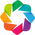

-783.4221453287198 474.5778546712802 -783.4221 474.57785


In [9]:
from sep_python import get_sep_vector
from sep_plot import Grey
xy = np.stack((xar, yar))
avg=np.sum(zar)/zar.shape[0]
zar[:]=zar[:]-avg
zvec=get_sep_vector(zar)

data=get_sep_vector(reg_model)
binOp=Bin2D(data,zvec,xy)
ones=zvec.clone()
ones[:]=1
binOp.adjoint(False,data,zvec)
sc=data.clone()
binOp.adjoint(False,sc,ones)
for i2 in range(sc.shape[0]):
    for i1 in range(sc.shape[1]):
        if sc[i2,i1]!=0:
            data[i2,i1]/=sc[i2,i1]

#Grey(data)
d=data.get_nd_array()
print(zar.min(),zar.max(),d.min(),d.max())

## Our data fitting operator

Our data fitting operator will have 1s where we have known data 0 everywhere else

In [10]:
import copy
from generic_solver._pyOperator import Operator
class Jop(Operator):

    def __init__(self, mod, dat, not_data=0):
        """
        Initialize our selector operator
        """
        super().__init__(mod, dat)

        self._jop=dat.clone()

        hyper=model.get_hyper()
        
        ax0 = hyper.axes[0]
        n1, o1, d1 = ax0.n, ax0.o, ax0.d
        
        ax1 = hyper.axes[1]
        n2, o2, d2 = ax1.n, ax1.o, ax1.d

        for i2 in range(n2):
            for i1 in range(n1):
                if self._jop[i2,i1] == not_data:
                    self._jop[i2,i1]=0
                else:
                    self._jop[i2,i1]=1


    def forward(self, add, mod, dat):
        """
        Forward operation.
        """
        self.checkDomainRange(mod, dat)
        if not add:
            dat.zero()
        dat[:,:]=dat[:,:]+mod[:,:]*self._jop[:,:]


    def adjoint(self, add, mod, dat):
        """
        Adjoint operation.
        """
        self.checkDomainRange(mod, dat)
        if not add:
            mod.zero()
        mod[:,:]=mod[:,:]+dat[:,:]*self._jop[:,:]



## Regularization operator

Here is a simple laplacian operator

In [11]:
import copy
from generic_solver._pyOperator import Operator
from numba import njit
class Lap(Operator):

    def __init__(self, mod, dat):
        """
        Laplacian operator
        """
        super().__init__(mod, dat)

        self._jop=dat.clone()
        
        

    def forward(self, add, mod, dat):
        """
        Forward operation.
        """
        self.checkDomainRange(mod, dat)
        if not add:
            dat.zero()
        lap_forward(mod.get_nd_array(),dat.get_nd_array())


    def adjoint(self, add, mod, dat):
        """
        Adjoint operation.
        """
        self.checkDomainRange(mod, dat)
        if not add:
            mod.zero()
        lap_adjoint(mod.get_nd_array(),dat.get_nd_array())

@njit
def lap_forward(mod,dat):
    for i2 in range(1,dat.shape[0]-1):
        for i1 in range(1,dat.shape[1]-1):
            dat[i2,i1]+=mod[i2,i1]*4-mod[i2-1,i1]-mod[i2+1,i1]-mod[i2,i1-1]-mod[i2,i1+1]
        
        
@njit
def lap_adjoint(mod,dat):
    for i2 in range(1,dat.shape[0]-1):
        for i1 in range(1,dat.shape[1]-1):
            mod[i2,i1]+=dat[i2,i1]*4
            mod[i2,i1-1]-=dat[i2,i1]
            mod[i2,i1+1]-=dat[i2,i1]
            mod[i2+1,i1]-=dat[i2,i1]
            mod[i2-1,i1]-=dat[i2,i1]

     


## Setup our inversion problem

In [12]:
from generic_solver import ProblemL2LinearReg, BasicStopper
#from generic_solver._pyLinearSolver import LCGsolver
from generic_solver import LCGsolver

model=data.clone()
jop=Jop(model,data)
lap=Lap(model,data)
eps=1
prob=ProblemL2LinearReg(model,data,jop,eps,reg_op=lap)
stop=BasicStopper(niter=500)
solve=LCGsolver(stop)
solve.run(prob,verbose=True)



##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2023-10-28T17-23-31.729255/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 000, obj = 1.13420e+08, resnorm = 1.51e+04, gradnorm = 9.33e+04, feval = 2
iter = 001, obj = 1.88661e+07, resnorm = 6.14e+03, gradnorm = 2.66e+04, feval = 4
iter = 002, obj = 7.62747e+06, resnorm = 3.91e+03, gradnorm = 1.23e+04, feval = 6
iter = 003, obj = 4.94303e+06, resnorm = 3.14e+03, gradnorm = 6.83e+03, feval = 8
iter = 004, obj = 3.99351e+06, resnorm = 2.83e+03, gradnorm = 4.54e+03, feval = 10
iter = 005, obj = 3.49138e+06, resnorm = 2.64e+03, gradnorm = 3.56e+03, feval = 12
iter = 006, obj = 3.14987e+06, resnorm = 2.51e+03, gradnorm = 2.91e+03, feval = 14
iter = 007, obj = 2.94532e+06, resnorm = 2.43e+03, gradnorm = 2.36e+03, feval = 16
iter = 008, obj = 2.79110e+06, 

## Plot

Take a look at the inverted model. It appears that we didn't accomplish much. Experiment with changing epsilon.

In [13]:
Grey(prob.model)+Grey(data)

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

## Residuals 
Remember we have two residuals. The first is how well we've fit the data. Second, how much our model
fits are convariance definition.

In [14]:
Grey(prob.res.vecs[0])+Grey(prob.res.vecs[1])

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

## Improving our boundary condition

As discussed in class we are far from IID.  So lets fill in edge values using an inverse distance squared.

In [15]:

def find_val(x,y,xloc,yloc,z):
    wt=(x-xloc)*(x-xloc)+(y-yloc)*(y-yloc)+.001
    wt=wt*wt
    return np.sum(1./wt*z)/np.sum(1/wt)

for i2 in range(data.shape[0]):
    data[i2,0]=find_val(o1,o2+d2*i2,xar,yar,zar)
    data[i2,data.shape[1]-1]=find_val(o1+d1*data.shape[1]-1,o2+d2*i2,xar,yar,zar)
for i1 in range(data.shape[1]):
    data[0,i1]=find_val(o1+d1*i1,o2,yar,xar,zar)
    data[data.shape[0]-1,i1]=find_val(o1+d1*i1,o2+d2*data.shape[0]-1,xar,yar,zar)

Grey(data)


[-81.39544  -81.1602   -80.883125 -80.56498  -80.206726 -79.80948
 -79.37451  -78.90324  -78.39716  -77.85793  -77.28728  -76.68698
 -76.05889  -75.404915 -74.72697  -74.02697  -73.30685  -72.56851
 -71.81385  -71.0447   -70.26285  -69.47005  -68.66797  -67.85823
 -67.04236  -66.22182  -65.398    -64.57222  -63.745693 -62.919567
 -62.09492  -61.272743 -60.45395  -59.63939  -58.82983  -58.025986
 -57.22849  -56.437927 -55.654816 -54.87962 ]


:Image   [x,y]   (z)

In [23]:
jop=Jop(model,data)
lap=Lap(model,data)
model.zero()
eps=.001
prob=ProblemL2LinearReg(model,data,jop,eps,reg_op=lap)
stop=BasicStopper(niter=500)
solve=LCGsolver(stop)
solve.setDefaults(save_grad=True)
solve.run(prob,verbose=True)


##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2023-10-28T17-24-17.595469/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 000, obj = 1.26233e+07, resnorm = 5.02e+03, gradnorm = 5.02e+03, feval = 2
iter = 001, obj = 1.15947e+02, resnorm = 1.52e+01, gradnorm = 8.12e-02, feval = 4
iter = 002, obj = 1.15938e+02, resnorm = 1.52e+01, gradnorm = 1.05e-01, feval = 6
iter = 003, obj = 3.73467e+01, resnorm = 8.64e+00, gradnorm = 4.46e-01, feval = 8
iter = 004, obj = 3.72469e+01, resnorm = 8.63e+00, gradnorm = 2.38e-02, feval = 10
iter = 005, obj = 3.13759e+01, resnorm = 7.92e+00, gradnorm = 2.08e+00, feval = 12
iter = 006, obj = 2.79301e+01, resnorm = 7.47e+00, gradnorm = 1.28e-02, feval = 14
iter = 007, obj = 2.79039e+01, resnorm = 7.47e+00, gradnorm = 2.28e-01, feval = 16
iter = 008, obj = 2.36859e+01, 

In [18]:
Grey(prob.model)

:Image   [x,y]   (z)

In [19]:
Grey(prob.res.vecs[0])+Grey(prob.res.vecs[1])

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

In [20]:
print(prob.get_model()[:3,:3])


[[ -81.403145  -81.4415    -81.42038 ]
 [-114.639915 -104.68568  -102.962105]
 [-120.16707  -119.44971  -121.274185]]


In [21]:
Grey(solve.modelSet.vecSet[1])

IndexError: list index out of range